<a href="https://colab.research.google.com/github/NATGMCK/N611Simulator/blob/main/N611_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!easy_install -U scikit-fuzzy
!pip install scikit-fuzzy
!pip install opem
from math import e
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import random
from opem.Static.Amphlett import Static_Analysis
from math import log

###Modelo Panel Solar

In [ ]:
def SolarPanel(V,I,G,PLoad):      #Voltage,Current,Radiance,Power Load
    Ki=0.05                       #Shot-circuit current at 25°C and 1000W/m^2
    Tn=298                        #Nominal temperature
    q=1.6*10**(-19)               #Electron charge
    n=0.5                         #Ideality factor of the diode
    K=1.38*10**(-23)              #Boltzmann's Constant
    Eg0=1.1                       #Band gap energy of the semiconductor
    Ns=114                        #Number of cells in series
    Np=1                          #Number of cells in parallel
    Rs=0.221                      #Series Resistance
    Rsh=415.405                   #Shunt Resistance
    Pmp=210                       #Rated power
    Vmp=18.3                      #Voltage at maximun power
    Imp=11.48                     #Current ar maximun power
    Voc=22.8                      #Open circuit voltage
    Isc=12.11                     #Short circuit current
    I=0                           #Output Current
    T=298                         #Temperature       
    #Reverse saturation current
    Irs=Isc/(e**((q*Voc)/(n*Ns*K*T))-1)
    #Saturation Current 
    Io=e**(((1/Tn-1/T)*Eg0*q)/(n*K))*Irs*(T/Tn)**3
    #Photo-current
    Iph=(Isc+Ki*(T-Tn))*(G/1000) 
    #Current through shunt resistor
    Ish=(V+Rs)/Rsh
    #Output Current
    I_out=Iph-Io*(e**((q*(V+I*Rs))/(n*K*Ns*T))-1)-Ish
    if I_out*V-PLoad>0:
        P_out=PLoad
        I_out=P_out/V
    else: 
        P_out=I_out*V
        if P_out<=0:
          P_out=0
          I_out=0
    EffD=0.94 #Eff Diode
    EffACDC=0.85 #Eff  AC DC Converter
    EffDCDC=0.85 # Eff  DC DC Converter
    EffDCAC=0.85 #Eff Inverter
    P_out=P_out/(EffDCDC*EffD)
    if P_out>210:
      P_out=210
    return I_out,P_out

###Modelo PEMFC

In [ ]:
F=96485 #Constante de Faraday
R=8.314 #Constante de los gases ideales
Tn=298.15 #Temperatura a condiciones normales
Pn=101325 #Presión a condiciones normales
n_cell=16 #Numero de celdas
T=298.15
Test_Vector={"T": T,"PH2": 1,"PO2": 1,"i-start": 0,"i-stop": 5,"i-step":0.01,"A": 100,"l": 0.0178,"lambda": 14,"N": n_cell,"R": 0,"JMax": 1.5,"Name": "Amphlett_Test"}
data=Static_Analysis(InputMethod=Test_Vector,TestMode=True,PrintMode=False,ReportMode=False)
Power_FCModel=data['P'] 
Current_FCModel=data['I'] 
Voltage_FCModel=data['V'] 
Efficiency_FCModel=data['EFF']
H2FlowRate_FCModel=[] #En L/s
PEMFC_CURVE={}
for dp in range(len(Power_FCModel)):
  H2FlowRate_FCModel.append((((n_cell*Current_FCModel[dp])/(2*F))*(R*Tn)/Pn*1000))
  PEMFC_CURVE[round(Power_FCModel[dp])] = round(H2FlowRate_FCModel[dp],4)
def PEMFC(Power):
  global Tank_Level 
  if Power>60:
    Power=60
  try:
    Rate=-PEMFC_CURVE[Power]
  except:
    Rate=-PEMFC_CURVE[Power-1]
  Tank_Level=HydrogenTank(Rate)
  return Power

###Modelo PEMEL

In [ ]:
import numpy as np
plt.rcParams.update({'font.size': 15})
SCells=5 #Numero de celdas en serie 
PCells=0 #Numero de celdas en paralelo 
N_cell=SCells+PCells  #Number of electrolyzer cells 
R=8.32  #Contante de los gases ideales 
T_PEMEL=298.15  #Temperatura del electrolizador
Z=2 #Number of electrons required to release a molecule
P_PEMEL=0.1013  #atmospheric pressure
#Datos experiementales. Para más detalles: Using MATLAB to model and simulate a photovoltaic system to produce hydrogen
a=0.8018
b=0.0632
c=0.0482
I_PEMEL=np.arange(0.1,10,0.1)
V_PEMEL_a=[]
Q_PEMEL_a=[]
eff_PEMEL_a=[]
P_PEMEL_a=[]
PEMEL_CURVE={}
for i in range(len(I_PEMEL)):
  V_PEMEL=(a+b*log(I_PEMEL[i])+c*I_PEMEL[i])*N_cell
  Power_PEMEL=round(V_PEMEL*I_PEMEL[i])
  Q_PEMEL=round(((N_cell*R*I_PEMEL[i]*T_PEMEL)/(Z*F*P_PEMEL))/1000,4)  #Volume of hydrogen produced
  eff_PEMEL=((1.23*SCells)/V_PEMEL)*100 #Eficiencia de la celda
  PEMEL_CURVE[Power_PEMEL] = Q_PEMEL
  V_PEMEL_a.append(V_PEMEL)
  Q_PEMEL_a.append((N_cell*R*I_PEMEL[i]*T_PEMEL)/(Z*F*P_PEMEL))
  P_PEMEL_a.append(Power_PEMEL)
  eff_PEMEL_a.append(eff_PEMEL)
def PEMEL(Power):
  global Tank_Level
  if Power>70:
    Power=70
  elif Power==0:
    Rate=0
  else:
    try:
      Rate=PEMEL_CURVE[Power]
    except:
      Rate=PEMEL_CURVE[Power-1]
  Tank_Level=HydrogenTank(Rate)
  return Power


###Modelo Tanque

In [ ]:
global Tank_Level
Tank_Level=100
#Recharge_time=7 #Hours
def HydrogenTank(HydrogenFlow): #PEMEL + , PEMFC -
  global Tank_Level
  Tank_capacity=120 #Standard liters
  Tank_Level=Tank_Level+HydrogenFlow
  if Tank_Level>Tank_capacity:
    Tank_Level=Tank_capacity
  if Tank_Level<0:
    Tank_Level=0
  return Tank_Level

###Modelo Batería

In [ ]:
#Batería Recargable 12V-18Ah Magna ES18-12M
#Nominal Voltage 12V
#Capacidad 18ah
#Numero de celdas 2
global Batt_Storage
Batt_Storage=432 #wh
def Battery(Power): #Positivo para carga negativo para descarga
  Power=-Power
  EffD=0.94 #Eff Diode
  EffDCAC=0.85 #Eff Inverter
  global Batt_Storage
  if Power>0:       #Cargando
    if Batt_Storage>=432:
      PowerBatt=0
    if Batt_Storage<432:
      Batt_Storage+=Power/3600
      PowerBatt=Power
  if Power<=0:       #Descargando
    if abs(Power)>400:
      PowerBatt=-400
    else:
      PowerBatt=-Power/(EffDCAC*EffD)
  Batt_Storage=Batt_Storage-PowerBatt/3600
  Batt_Storage_Percent=Batt_Storage*(100/432)
  return PowerBatt,round(Batt_Storage_Percent,2)

###Modelo Grid

In [ ]:
def Grid(Power):
  EffD=0.94 #Eff Diode
  EffACDC=0.85 #Eff  AC DC Converter
  EffDCDC=0.85 # Eff  DC DC Converter
  EffDCAC=0.85 #Eff Inverter
  PowerGrid=(Power/(EffACDC*EffD*EffDCDC*EffD*EffDCDC*EffDCAC))+random.randint(5,8) #Random para las perdidas por los leds y perdidas no contempladas
  return PowerGrid

### MPPT por Lógica Difusa

In [ ]:
error_delta = ctrl.Antecedent(np.arange(-30, 20, 0.1), 'error_delta')
voltage_delta = ctrl.Consequent(np.arange(-0.5,0.5, 0.01), 'voltage_delta')

error_delta['negative big'] = fuzz.trimf(error_delta.universe,[-30,-30, -20])
error_delta['negative medium'] = fuzz.trapmf(error_delta.universe, [-25,-20,-10, -5])
error_delta['negative small'] = fuzz.trapmf(error_delta.universe, [-8,-7,-1, -0])
error_delta['zero'] = fuzz.trapmf(error_delta.universe, [0, 1,5, 6])
error_delta['positive small'] = fuzz.trapmf(error_delta.universe, [5, 6,8, 10])
error_delta['positive medium'] = fuzz.trapmf(error_delta.universe, [8, 10,12, 15])
error_delta['positive big'] = fuzz.trapmf(error_delta.universe, [12, 15, 20, 20])
  
voltage_delta['negative big'] = fuzz.trapmf(voltage_delta.universe,[-0.5, -0.5,-0.3,-0.2])
voltage_delta['negative medium'] = fuzz.trimf(voltage_delta.universe,[-0.3,-0.2,-0.1])
voltage_delta['negative small'] = fuzz.trimf(voltage_delta.universe, [-0.2,-0.1,0])
voltage_delta['zero'] = fuzz.trimf(voltage_delta.universe, [-0.1, 0, 0.1])
voltage_delta['positive small'] = fuzz.trimf(voltage_delta.universe, [0, 0.1, 0.2])
voltage_delta['positive medium'] = fuzz.trimf(voltage_delta.universe, [0.1, 0.2, 0.3])
voltage_delta['positive big'] = fuzz.trapmf(voltage_delta.universe, [0.2, 0.3,0.5,0.5])
      
rule1 = ctrl.Rule(error_delta['negative big'], voltage_delta['negative big'])
rule2 = ctrl.Rule(error_delta['negative medium'], voltage_delta['negative medium'])
rule3 = ctrl.Rule(error_delta['negative small'], voltage_delta['negative small'])
rule4 = ctrl.Rule(error_delta['zero'], voltage_delta['zero'])
rule5 = ctrl.Rule(error_delta['positive small'], voltage_delta['positive small'])
rule6 = ctrl.Rule(error_delta['positive medium'], voltage_delta['positive medium'])
rule7 = ctrl.Rule(error_delta['positive big'], voltage_delta['positive big'])

setting_ctrl = ctrl.ControlSystem([rule1,rule2, rule3, rule4, rule5,rule6,rule7])
setting = ctrl.ControlSystemSimulation(setting_ctrl)

### Selector de estados por lógica difusa

In [ ]:
PowerPanel_F = ctrl.Antecedent(np.arange(0, 210, 0.1), 'PowerPanel_F')
PowerBatt_F = ctrl.Antecedent(np.arange(0, 210, 0.1), 'PowerBatt_F')
performance=ctrl.Consequent(np.arange(-1,1.1, 0.1), 'performance')

PowerPanel_F['zero'] = fuzz.trimf(PowerPanel_F.universe,[0,0, 10]) 
PowerPanel_F['low'] =  fuzz.trapmf(PowerBatt_F.universe,[5,10,60, 70])  
PowerPanel_F['medium'] =  fuzz.trapmf(PowerPanel_F.universe, [60,70,150, 160])   
PowerPanel_F['high'] = fuzz.trapmf(PowerPanel_F.universe, [150, 160,210, 210])  

PowerBatt_F['zero'] = fuzz.trimf(PowerBatt_F.universe,[0,0, 10]) 
PowerBatt_F['low'] = fuzz.trapmf(PowerBatt_F.universe,[5,10,60, 70])  
PowerBatt_F['medium'] = fuzz.trapmf(PowerPanel_F.universe, [60,70,150, 160])   
PowerBatt_F['high'] = fuzz.trapmf(PowerPanel_F.universe, [150, 160,210, 210])

performance['poor'] = fuzz.trimf(performance.universe, [-1,-1,0]) 
performance['normal'] = fuzz.trimf(performance.universe, [-1,0,1])  
performance['high'] = fuzz.trimf(performance.universe, [0,1,1]) 

rule1 = ctrl.Rule(PowerPanel_F['low'] & PowerBatt_F['low'], performance['poor'])
rule2 = ctrl.Rule((PowerPanel_F['high']|PowerPanel_F['medium']) & (PowerBatt_F['high']|PowerBatt_F['medium']|PowerBatt_F['low']), performance['poor'])
rule3 = ctrl.Rule(PowerPanel_F['zero'], performance['poor'])  #Para ir a s4
rule4 = ctrl.Rule((PowerPanel_F['low']|PowerPanel_F['medium']) & PowerBatt_F['zero'], performance['high'])
rule5 = ctrl.Rule((PowerPanel_F['high']|PowerPanel_F['low'] )& PowerBatt_F['zero'], performance['high'])
rule6 = ctrl.Rule((PowerPanel_F['low'])& (PowerBatt_F['high']|PowerBatt_F['medium']), performance['poor'])
rule7 = ctrl.Rule(PowerPanel_F['high'] & PowerBatt_F['zero'], performance['normal'])
rule8 = ctrl.Rule((PowerBatt_F['high']|PowerBatt_F['medium']), performance['poor'])

setting_state = ctrl.ControlSystem([rule1,rule2, rule3, rule4, rule5,rule6,rule7,rule7])
setting_s = ctrl.ControlSystemSimulation(setting_state)

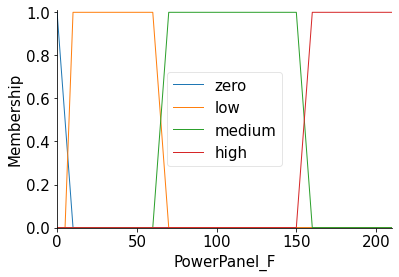

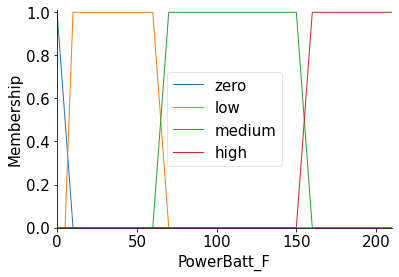

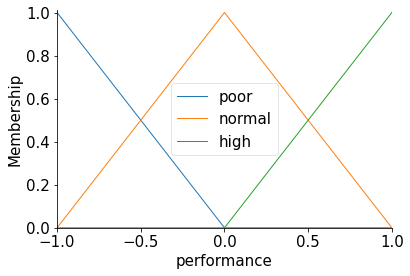

In [ ]:
PowerPanel_F.view()
PowerBatt_F.view()
performance.view()


In [ ]:
def SoftDecider(PanelPower,PowerBatt,S):
  setting_s.input['PowerPanel_F'] = PanelPower
  setting_s.input['PowerBatt_F'] = PowerBatt
  setting_s.compute()
  result=round(setting_s.output['performance'])

  if result==1:
    if S==1 or S==2:
      S=3
    elif S==4:
      S=1
  elif result==-1:
    if S==1:
      S=4
    elif S==2:
      S=1
    elif S==3:
      S=2
  return S

In [ ]:
def HardDecider(S,PanelPower,PowerGrid,PowerLoad):
  if S==1:
    if PanelPower>0 and PowerGrid<PowerLoad and PowerGrid!=0:
      S=1
    elif PanelPower>0 and PowerGrid==0:
      S=3
    elif PowerGrid>PowerLoad:
      S=4
  elif S==2:
    if PanelPower>0 and PowerGrid==0:
      S=2
    else:
      S=1
  elif S==3:
    if PanelPower>0 and PowerGrid==0:
      S=3
    else:
      S=2
  elif S==4:
    if PowerGrid>PowerLoad:
      S=4
    else:
      S=1
  return S

###Control de Estados

In [ ]:
#Datos para pruebas
Radiation=[	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	2,	5,	8,	13,	18,	25,	28,	43,	48,	54,	60,	65,	65,	83,	89,	98,	158,	188,	186,	225,	255,	288,	296,	361,	369,	416,	376,	441,	506,	560,	563,	652,	734,	743,	726,	731,	236,	794,	817,	847,	818,	424,	796,	862,	884,	908,	853,	903,	937,	911,	906,	900,	924,	937,	913,	906,	780,	862,	924,	970,	970,	990,	990,	974,	995,	940,	859,	982,	1088,	269,	982,	1033,	1044,	871,	288,	1055,	988,	1027,	998,	969,	983,	993,	584,	991,	1058,	1009,	894,	915,	892,	838,	821,	840,	841,	797,	750,	768,	725,	644,	562,	557,	586,	443,	389,	530,	571,	571,	605,	591,	553,	528,	459,	494,	482,	416,	405,	374,	374,	363,	318,	297,	257,	246,	242,	220,	185,	171,	149,	115,	110,	94,	80,	65,	57,	48,	39,	33,	25,	20,	15,	10,	6,	3,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0]
#Radiation=[	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	3,	6,	11,	16,	22,	28,	34,	36,	44,	57,	78,	77,	81,	82,	89,	146,	162,	225,	189,	174,	155,	193,	192,	341,	184,	181,	190,	446,	470,	536,	566,	607,	200,	274,	691,	534,	500,	674,	619,	615,	314,	321,	328,	263,	316,	744,	330,	441,	396,	279,	264,	269,	290,	312,	331,	368,	610,	479,	442,	694,	538,	773,	1218,	983,	1006,	1040,	861,	1027,	1023,	968,	608,	1078,	1058,	1077,	990,	734,	1033,	1065,	1009,	324,	1016,	1009,	1006,	1037,	1024,	986,	969,	972,	910,	923,	862,	872,	850,	876,	783,	783,	760,	672,	660,	666,	592,	551,	480,	602,	636,	628,	617,	587,	535,	524,	488,	495,	481,	433,	401,	355,	355,	360,	297,	292,	239,	241,	228,	218,	181,	174,	149,	117,	112,	98,	84,	69,	61,	54,	46,	38,	31,	23,	17,	11,	7,	3,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0]
#Radiation=[	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	2,	6,	10,	16,	23,	34,	38,	46,	54,	61,	69,	75,	82,	92,	90,	134,	196,	183,	191,	208,	253,	296,	349,	368,	380,	393,	419,	430,	443,	520,	533,	592,	638,	647,	613,	424,	423,	737,	650,	528,	265,	309,	293,	726,	885,	370,	865,	897,	999,	1004,	655,	427,	388,	351,	485,	399,	365,	631,	766,	1098,	1111,	1146,	1032,	492,	1022,	892,	431,	940,	1081,	1004,	1031,	977,	993,	1020,	1005,	982,	940,	681,	986,	928,	350,	879,	935,	906,	907,	859,	904,	859,	836,	826,	842,	815,	895,	900,	814,	825,	637,	599,	686,	642,	663,	602,	608,	604,	638,	632,	202,	246,	543,	426,	478,	517,	514,	433,	413,	339,	357,	351,	280,	283,	232,	243,	235,	213,	182,	174,	146,	115,	111,	101,	87,	71,	63,	55,	48,	40,	33,	25,	18,	12,	7,	3,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0]
#Radiation=[	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	3,	5,	10,	15,	22,	27,	43,	45,	49,	55,	70,	81,	82,	87,	93,	113,	157,	184,	208,	220,	243,	278,	315,	357,	389,	355,	390,	453,	504,	544,	555,	646,	688,	734,	695,	719,	710,	756,	757,	785,	832,	829,	832,	807,	835,	865,	857,	894,	905,	407,	813,	855,	862,	560,	943,	737,	255,	959,	938,	957,	1005,	1068,	1039,	961,	1020,	997,	954,	937,	973,	1014,	1009,	982,	970,	974,	1017,	929,	918,	912,	947,	893,	862,	882,	917,	869,	864,	866,	850,	809,	847,	825,	769,	781,	816,	811,	777,	743,	748,	711,	596,	564,	571,	575,	418,	414,	553,	555,	577,	595,	561,	548,	479,	465,	479,	442,	398,	387,	382,	349,	326,	320,	287,	275,	246,	229,	200,	177,	152,	126,	109,	98,	88,	69,	62,	55,	47,	39,	32,	25,	18,	12,	7,	3,	1,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0]

#Carga Residencial Típica
EL_PowerLoad=[	24,	24,	24,	26,	24,	21,	20,	29,	26,	21,	29,	21,	20,	22,	24,	25,	20,	17,	25,	17,	19,	17,	19,	22,	20,	17,	18,	19,	22,	22,	16,	23,	25,	22,	15,	18,	26,	26,	26,	26,	30,	25,	30,	28,	22,	23,	28,	24,	22,	21,	26,	23,	28,	24,	29,	21,	30,	23,	28,	27,	23,	22,	23,	24,	26,	30,	30,	22,	25,	29,	23,	29,	27,	20,	26,	28,	29,	29,	28,	24,	22,	21,	27,	30,	27,	22,	30,	22,	29,	29,	24,	23,	25,	21,	28,	27,	20,	30,	23,	28,	27,	30,	21,	27,	20,	23,	22,	30,	27,	22,	25,	22,	25,	20,	30,	26,	29,	28,	23,	28,	26,	25,	28,	21,	28,	22,	27,	28,	27,	26,	26,	29,	27,	28,	21,	30,	29,	24,	24,	29,	27,	30,	24,	27,	26,	27,	21,	28,	20,	21,	29,	25,	20,	20,	28,	26,	26,	28,	20,	23,	27,	20,	26,	30,	23,	27,	22,	21,	29,	24,	25,	26,	26,	26,	25,	26,	25,	23,	24,	23,	21,	22,	20,	21,	20,	30,	23,	23,	29,	24,	22,	28,	25,	23,	27,	30,	27,	22,	26,	23,	26,	29,	27,	28,	25,	21,	30,	29,	30,	27,	21,	22,	26,	22,	27,	29,	25,	28,	28,	26,	21,	30,	26,	22,	20,	23,	28,	27,	20,	23,	25,	27,	23,	20,	24,	24,	24,	25,	21,	24,	23,	25,	23,	28,	25,	29,	21,	29,	20,	28,	21,	23,	24,	25,	26,	26,	30,	30,	26,	24,	29,	20,	28,	26,	20,	29,	26,	27,	23,	21,	20,	21,	26,	28,	25,	27,	26,	30,	20,	30,	24,	25,	22,	28,	20,	28,	23,	29	]
NEL_PowerLoad=[	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	20,	23,	11,	19,	15,	13,	11,	24,	12,	18,	16,	19,	53,	50,	48,	47,	50,	49,	47,	57,	47,	48,	55,	43,	72,	80,	68,	68,	72,	73,	69,	74,	75,	83,	71,	64,	67,	76,	61,	76,	67,	63,	71,	75,	69,	73,	63,	64,	65,	54,	65,	52,	63,	50,	59,	54,	68,	63,	58,	52,	57,	57,	57,	59,	57,	59,	49,	54,	55,	52,	64,	52,	58,	58,	55,	58,	59,	64,	55,	56,	54,	56,	63,	60,	53,	50,	63,	52,	52,	60,	54,	46,	57,	49,	57,	56,	50,	53,	60,	52,	52,	54,	42,	52,	60,	53,	44,	53,	50,	43,	60,	55,	51,	58,	49,	45,	52,	50,	53,	54,	54,	61,	53,	55,	53,	58,	55,	57,	60,	61,	63,	65,	77,	80,	75,	76,	82,	67,	71,	80,	73,	75,	72,	73,	94,	93,	87,	93,	88,	93,	90,	91,	97,	85,	93,	87,	108,	112,	108,	102,	106,	110,	115,	115,	104,	112,	107,	105,	115,	112,	117,	117,	122,	108,	112,	116,	115,	121,	111,	113,	122,	116,	115,	112,	120,	121,	118,	114,	113,	120,	120,	117,	109,	108,	114,	108,	105,	100,	115,	107,	117,	101,	107,	111,	81,	84,	84,	75,	74,	70,	78,	80,	77,	80,	78,	84,	52,	39,	47,	44,	45,	49,	51,	52,	48,	43,	51,	44,	13,	10,	23,	14,	16,	18,	20,	9,	24,	7,	15,	8	]
#Carga Bloque K																																																																																																																																																																																																																																																																																																
#EL_PowerLoad=[	50,	45,	48,	52,	41,	45,	53,	54,	54,	46,	43,	57,	46,	44,	46,	53,	42,	55,	55,	43,	44,	57,	58,	42,	41,	54,	46,	44,	56,	58,	40,	41,	46,	42,	55,	58,	42,	60,	43,	45,	53,	45,	46,	42,	47,	50,	47,	58,	53,	48,	45,	57,	43,	56,	48,	58,	42,	52,	48,	43,	43,	55,	46,	44,	59,	55,	42,	57,	51,	59,	54,	50,	52,	49,	58,	55,	47,	58,	47,	44,	56,	40,	60,	48,	58,	56,	43,	43,	40,	54,	52,	52,	41,	50,	57,	44,	54,	47,	40,	53,	60,	46,	57,	51,	47,	40,	47,	47,	47,	49,	40,	56,	49,	60,	50,	52,	54,	56,	51,	46,	59,	49,	40,	56,	59,	60,	46,	59,	48,	54,	56,	53,	46,	59,	42,	46,	53,	55,	42,	54,	51,	43,	50,	50,	55,	42,	40,	49,	40,	40,	43,	60,	51,	57,	45,	52,	48,	43,	43,	42,	45,	53,	47,	51,	53,	52,	45,	52,	45,	59,	51,	45,	53,	40,	42,	59,	50,	49,	45,	53,	56,	54,	46,	45,	57,	42,	48,	45,	55,	50,	58,	45,	49,	41,	40,	43,	43,	43,	50,	44,	48,	48,	43,	52,	54,	46,	51,	44,	46,	44,	44,	47,	42,	49,	49,	54,	50,	44,	48,	48,	43,	56,	57,	58,	42,	56,	56,	40,	48,	58,	42,	45,	57,	53,	41,	50,	41,	54,	53,	52,	50,	53,	58,	55,	44,	51,	47,	41,	58,	51,	55,	41,	50,	56,	42,	47,	45,	53,	60,	47,	59,	46,	50,	54,	40,	52,	50,	43,	55,	51,	44,	55,	59,	59,	54,	42,	56,	59,	44,	56,	42,	42,	56,	54,	54,	57,	52,	40	]
#NEL_PowerLoad=	[0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	46,	42,	54,	52,	40,	51,	55,	54,	58,	70,	39,	43,	51,	36,	39,	46,	54,	47,	56,	58,	44,	52,	42,	48,	38,	60,	52,	39,	35,	52,	56,	35,	41,	63,	49,	46,	45,	48,	36,	48,	48,	37,	54,	56,	31,	48,	49,	45,	52,	59,	54,	52,	61,	59,	59,	51,	66,	60,	47,	53,	60,	50,	46,	47,	38,	62,	42,	57,	57,	47,	53,	48,	51,	53,	56,	37,	39,	53,	38,	46,	35,	43,	52,	39,	68,	51,	39,	45,	53,	59,	54,	42,	36,	58,	60,	33,	52,	59,	57,	35,	41,	34,	62,	58,	63,	56,	61,	49,	59,	42,	65,	54,	52,	64,	40,	44,	60,	58,	48,	51,	46,	54,	57,	55,	56,	48,	38,	52,	47,	60,	52,	66,	41,	50,	34,	64,	37,	46,	67,	52,	52,	50,	57,	50,	51,	63,	40,	67,	41,	50,	54,	40,	42,	49,	38,	54,	59,	43,	51,	32,	47,	51,	64,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0	]
#Carga Alta																																																																																																																																																																																																																																																																																															
#EL_PowerLoad=[	0,	46,	59,	33,	48,	48,	35,	36,	37,	38,	53,	31,	53,	37,	43,	36,	60,	44,	32,	41,	45,	59,	60,	47,	45,	39,	40,	54,	60,	37,	31,	32,	59,	54,	47,	35,	36,	33,	45,	35,	49,	37,	45,	37,	57,	43,	51,	60,	40,	46,	44,	37,	42,	57,	49,	47,	51,	37,	51,	37,	53,	52,	54,	31,	52,	43,	43,	49,	36,	60,	38,	56,	52,	43,	60,	43,	36,	58,	59,	54,	43,	48,	31,	40,	33,	44,	51,	56,	48,	43,	39,	54,	38,	42,	35,	38,	30,	36,	60,	55,	37,	49,	57,	50,	39,	39,	43,	59,	49,	59,	31,	30,	51,	59,	40,	44,	51,	44,	60,	36,	46,	34,	52,	34,	39,	60,	46,	51,	51,	33,	39,	42,	57,	40,	45,	31,	30,	30,	55,	31,	53,	51,	46,	37,	41,	52,	38,	52,	47,	51,	57,	40,	55,	35,	59,	42,	42,	41,	59,	53,	60,	52,	30,	31,	53,	34,	40,	31,	50,	34,	57,	41,	46,	58,	33,	53,	37,	32,	40,	50,	51,	39,	50,	55,	30,	47,	33,	35,	58,	44,	37,	55,	42,	45,	38,	36,	51,	60,	52,	47,	38,	34,	35,	46,	50,	59,	44,	47,	47,	32,	46,	48,	59,	44,	50,	34,	40,	31,	52,	47,	40,	44,	51,	55,	60,	41,	59,	47,	40,	60,	36,	50,	35,	59,	60,	58,	60,	58,	52,	32,	60,	55,	34,	30,	34,	49,	37,	49,	40,	34,	52,	45,	40,	51,	43,	59,	57,	42,	38,	48,	36,	36,	31,	43,	51,	50,	32,	32,	40,	39,	52,	50,	52,	44,	44,	51,	36,	31,	48,	52,	36,	60,	35,	39,	49,	40,	47,	0	]
#NEL_PowerLoad=[	0,	134,	100,	125,	146,	102,	161,	128,	147,	168,	118,	144,	119,	143,	155,	126,	139,	109,	152,	134,	154,	133,	109,	142,	117,	146,	158,	133,	119,	115,	122,	167,	151,	122,	127,	129,	154,	132,	141,	155,	131,	147,	148,	128,	128,	119,	102,	140,	150,	138,	158,	147,	152,	141,	147,	107,	150,	129,	135,	134,	119,	100,	122,	136,	103,	135,	133,	147,	167,	141,	161,	153,	122,	111,	94,	108,	156,	149,	115,	147,	154,	160,	125,	147,	123,	143,	105,	105,	115,	125,	117,	114,	154,	141,	141,	164,	145,	114,	109,	96,	113,	104,	131,	138,	147,	153,	145,	140,	141,	132,	148,	132,	115,	107,	169,	148,	159,	149,	94,	168,	160,	172,	140,	138,	134,	95,	156,	128,	138,	138,	150,	127,	93,	134,	132,	141,	167,	137,	117,	173,	112,	147,	159,	129,	118,	112,	120,	137,	152,	102,	114,	153,	134,	125,	121,	117,	109,	166,	107,	114,	104,	109,	179,	160,	157,	159,	155,	165,	119,	131,	93,	118,	162,	92,	119,	145,	119,	132,	125,	157,	158,	118,	159,	146,	177,	122,	132,	141,	127,	164,	164,	129,	124,	137,	166,	152,	133,	137,	105,	146,	122,	165,	157,	108,	156,	115,	138,	103,	146,	123,	105,	120,	105,	126,	104,	116,	115,	173,	137,	134,	137,	127,	155,	127,	100,	159,	133,	109,	141,	133,	114,	106,	142,	142,	102,	145,	117,	133,	132,	134,	149,	104,	122,	161,	166,	143,	144,	115,	127,	160,	151,	150,	113,	148,	124,	105,	129,	130,	165,	111,	121,	128,	145,	144,	131,	103,	138,	126,	112,	125,	101,	153,	146,	151,	162,	119,	126,	159,	160,	100,	171,	108,	142,	120,	133,	145,	156,	32	]

#Sin interrupciones
GridFlag=[	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1	]
#Todas interrupciones
#GridFlag=[	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0	]
#Con algunas interrupciones
#GridFlag=[	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1	]

#Datos de entrada
S=1
Batt_Storage=400
#Inicialización de variables
PowerLoad=[sum(x) for x in zip(EL_PowerLoad,NEL_PowerLoad)]
PowerLoad_a=[]
PanelPower_a_a=[]
PowerGrid_a=[]
PowerBatt_a=[]
PanelPower_a=[]
PanelVoltage_a=[]
TotalLoad=[]
Tank_Level_a=[]
PowerPEMFC_a=[]
TotalLoad_a=[]
State_a=[]

In [ ]:
def Time_Flag(Hora): #Pasar solo la hora en numeros del 1 al 24
  if Hora>=8 and Hora<=16:
    flag=True
  else:
    flag=False 
  return flag
########################################################################################################## Inicialización S1 ####################################################################################################
power_delta_a=[]
voltage_delta_a=[]
volt2affect=0
#Hacer diferencia entre potencia nominal y potencia real
Vdc=14 #Cargamos los vectores de potencia y voltage con valores iniciales y así evitar la división entre 0
(PanelCurrent,PanelPower)=SolarPanel(Vdc,0,Radiation[0],PowerLoad[0])
power_delta_a.append(PanelPower)
voltage_delta_a.append(Vdc)
Vdc=15
(PanelCurrent,PanelPower)=SolarPanel(Vdc,PanelCurrent,Radiation[0],PowerLoad[0])
power_delta_a.append(PanelPower)
voltage_delta_a.append(Vdc)
Vdc=16

########################################################################################################## Empiza Sistema ####################################################################################################

for n in range(len(Radiation)):                   #Aquí debe ir que mientras se tengan datos de entrada
  State_a.append(S)
  if S==1:################################################################################################ S1 #####################################################################################################
        (PanelCurrent,PanelPower)=SolarPanel(Vdc,PanelCurrent,Radiation[n],PowerLoad[n])
        if PanelPower>=0:
            power_delta_a.pop(0)
            voltage_delta_a.pop(0)
            power_delta_a.append(PanelPower)
            voltage_delta_a.append(Vdc)
            try:
              power_error=round((power_delta_a[1]-power_delta_a[0])/(voltage_delta_a[1]-voltage_delta_a[0]),3)
            except: 
              power_error=0.01        #Como es un entorno simulado, es posible que la resta de tensiones me de 0, así que en ese caso asigno el error como uno muy pequeño
            if power_error>=30:
                power_error=30
            if power_error<=-20:
                power_error=-20
            if Time_Flag(8):
                if PanelPower<1:    #Para evitar que se atasque cuando potencia del panel=0
                    Vdc=16  #Así, si es que nos salimos de los límites, volvemos al inicio, y si no hay radiacion quedamos en una tension relativamente elevada para alimentar cargas, cargar baterias y evitar perdidas por corriente elevada
                else:
                    setting.input['error_delta'] = power_error
                    setting.compute()
                    volt2affect = round(setting.output['voltage_delta'],3)
                    if volt2affect<=0.001:
                      volt2affect=0
                    Vdc=round(Vdc+volt2affect+random.random())#*random.choice([-0.1,0.1]),3)
                    if Vdc<=16:   #PONGO LÍMITES PARA LA TENSIÓN 
                      Vdc=16
                    if Vdc>=20:
                      Vdc=20
            else: 
                Vdc=16
        ###########################Valido el aporte de las otras fuentes##################
        PowerLeft=PowerLoad[n]-PanelPower
        if PowerLeft>0 and GridFlag[n]==1:
          PowerGrid=Grid(PowerLeft)
          PowerBatt=0
        elif PowerLeft>0 and GridFlag[n]==0:
          PowerGrid=Grid(0)
          aux=Battery(PowerLeft)
          PowerBatt=aux[0]
        else:     #Panel pudo con todo
          if Batt_Storage*(100/432)<50:
            (asfa,PowerCharge)=SolarPanel(Vdc,PanelCurrent,Radiation[n],210)
            PowerCharge=PowerCharge-PanelPower
            if PowerCharge>0:
              aux=Battery(-PowerCharge)
              PowerBatt=aux[0] 
              PanelPower+=-PowerBatt
              PowerGrid=Grid(0)
            elif GridFlag[n]==1:
              aux=Battery(-PowerCharge)
              PowerBatt=aux[0] 
              PowerGrid+=Grid(-PowerBatt)
            else:
              PowerBatt=0
              PowerGrid=Grid(0)
          else:
            PowerBatt=0
            PowerGrid=Grid(0)
        PW_PEMFC=0    
  if S==2:    ################################################################################################ S2 #####################################################################################################
    (PanelCurrent,PanelPower)=SolarPanel(Vdc,PanelCurrent,Radiation[n],PowerLoad[n])
    PowerLeft=PowerLoad[n]-PanelPower
    if PowerLeft>0:
      aux=Battery(PowerLeft)
      PowerBatt=aux[0]
    if PowerLeft<=0:
      PowerBatt=0
    else:
      if Batt_Storage*(100/432)<50 and PowerBatt==0:
        (asfa,PowerCharge)=SolarPanel(Vdc,PanelCurrent,Radiation[n],210)
        PowerCharge=PowerCharge-PanelPower
        if PowerCharge>0:
          aux=Battery(-PowerCharge)
          PowerBatt=aux[0] 
          PanelPower+=-PowerBatt
          PowerGrid=0
        else:
          PowerBatt=0
          PowerGrid=0
      else:
        PowerGrid=0
        PowerBatt=0 
    PW_PEMFC=0
  if S==3:  ################################################################################################ S3 #####################################################################################################
    PW_PEMEL=PEMEL(70)
    (PanelCurrent,PanelPower)=SolarPanel(Vdc,PanelCurrent,Radiation[n],PowerLoad[n])
    (PanelCurrent,PanelPower2)=SolarPanel(Vdc,PanelCurrent,Radiation[n],PW_PEMEL)
    PowerLeft=PowerLoad[n]-(PanelPower+PanelPower2)
    if PowerLeft>0:
      aux=Battery(PowerLeft)
      PowerBatt=aux[0]
    else:
      if Batt_Storage*(100/432)<50 and PowerBatt==0:
        (asfa,PowerCharge)=SolarPanel(Vdc,PanelCurrent,Radiation[n],210)
        PowerCharge=PowerCharge-PanelPower
        if PowerCharge>0:
          aux=Battery(-PowerCharge)
          PowerBatt=aux[0] 
          PanelPower+=-PowerBatt
          PowerGrid=0
        else:
          PowerBatt=0
          PowerGrid=0
      else:
        PowerGrid=0
        PowerBatt=0  
    PW_PEMFC=0
    PowerGrid=0
    
  if S==4:   ################################################################################################ S4 #####################################################################################################
  #Cargas escenciales
    GridSetPoint=16
    (PanelCurrent,PanelPower)=SolarPanel(GridSetPoint,PanelCurrent,Radiation[n],EL_PowerLoad[n])
    PowerLeft=EL_PowerLoad[n]-PanelPower
    Tank_Level_Perc=Tank_Level*100/120
    PowerGrid=Grid(0)
    if PowerLeft>0:
      if Tank_Level_Perc>30:
        PW_PEMFC=PEMFC(EL_PowerLoad[n])
        if EL_PowerLoad[n]>PW_PEMFC and GridFlag[n]==1:
          PowerGrid=Grid(EL_PowerLoad[n]-PW_PEMFC)
          PowerBatt=0
        elif EL_PowerLoad[n]>PW_PEMFC and GridFlag[n]==0:
          PowerGrid=Grid(0)
          aux=Battery(EL_PowerLoad[n]-PW_PEMFC)
          PowerBatt=aux[0]
        else:
          PowerGrid=0
          PowerBatt=0
      if Tank_Level_Perc<30:
        PW_PEMFC=0
        if GridFlag[n]==1:
          PowerGrid=Grid(PowerLeft)
          PowerBatt=0  
        else:
          aux=Battery(PowerLeft)
          PowerBatt=aux[0]   
          PowerGrid=Grid(0)
    if PowerLeft<0:      
      PW_PEMFC=0
      PowerGrid=Grid(0)
      PowerBatt=0
#Cargas no escenciales         
    if GridFlag[n]==1:
      PowerGrid+=Grid(NEL_PowerLoad[n])
    else:
      PowerGrid=Grid(0)
      NEL_PowerLoad[n]=0
  #############Decisor de estados######################
  S=SoftDecider(PanelPower,PowerBatt,S)
  #S=HardDecider(S,PanelPower,PowerGrid,PowerLoad[n])
  #############Decisor de estados######################
  TotalLoad=EL_PowerLoad[n]+NEL_PowerLoad[n]
  TotalLoad_a.append(TotalLoad)   
  PowerPEMFC_a.append(PW_PEMFC)   
  PanelPower_a.append(PanelPower)
  Tank_Level_a.append(Tank_Level)
  PowerGrid_a.append(PowerGrid)
  PowerBatt_a.append(PowerBatt) 

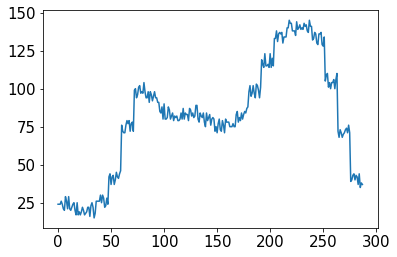

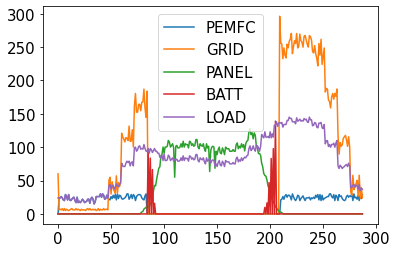

In [ ]:
plt.plot(PowerLoad)
plt.show()
plt.plot(PowerPEMFC_a)
plt.plot(PowerGrid_a)
plt.plot(PanelPower_a)
plt.plot(PowerBatt_a)
plt.plot(TotalLoad_a)
plt.legend(["PEMFC","GRID","PANEL","BATT","LOAD"])
plt.show()

file1 = open("Residencial_Hard.txt", "w") 
file1.write("%s = %s\n" %('Radiation: ',Radiation))
file1.write("%s = %s\n" %('Load: ',PowerLoad))
file1.write("%s = %s\n" %('PowerPEMFC_a: ',PowerPEMFC_a))
file1.write("%s = %s\n" %('PowerGrid_a: ',PowerGrid_a))
file1.write("%s = %s\n" %('PanelPower_a: ',PanelPower_a))
file1.write("%s = %s\n" %('PowerBatt_a: ',PowerBatt_a))
file1.write("%s = %s\n" %('TotalLoad_a: ',TotalLoad_a))
file1.write("%s = %s\n" %('TotalLoad_a: ',State_a))
file1.close()

